# 🚀 AI-Powered CV Ranking System - Hybrid RAG + LLM

## Advanced System Features:
✅ **Universal Job Support** - Works for ALL job categories (tech, marketing, healthcare, finance, etc.)  
✅ **Hybrid RAG + LLM** - Combines vector search with intelligent LLM analysis  
✅ **Role-Based Prompting** - LLM acts as HR expert with few-shot examples  


---





## System Architecture & Frameworks (Phase 1)

Frameworks Used:
- LangChain: orchestration, chains, prompts, and vectorstore integration.
- Sentence-Transformers (via HuggingFaceEmbeddings): embedding generation.
- ChromaDB: persistent vector storage (accessed through LangChain's Chroma wrapper).
- Groq Cloud (via langchain_groq/ChatGroq): LLM inference for analysis and ranking.

RAG Architecture:
1. Retrieval Phase
   - Semantic search using resume embeddings stored in Chroma.
   - Fast candidate retrieval with `vectorstore.as_retriever()`.
2. Augmentation Phase
   - LLM enrichment chain: extract skills, years, education, certifications, leadership, industries.
   - Uses role-based prompt templates via LangChain's PromptTemplate + LLMChain.
3. Generation / Ranking Phase
   - A ranking TransformChain computes hybrid scores (40% vector similarity + 60% LLM analysis).
   - Final LLM-based re-ranking (optional): uses LLM to produce human-readable explanations.

Model Architecture:
- Base Embedding Model: `all-MiniLM-L6-v2`  
- LLM: `llama-4.1-17b-instant` (Groq optimized) — used via ChatGroq wrapper.
- Hybrid Scoring: final_score = 0.4 * similarity + 0.6 * llm_score

Notes:
- All resume texts are stored as `langchain.schema.Document` objects with metadata.
- Chroma persistence directory kept at `./chroma_db`.



## Step 1: Install Required Packages

Install all necessary libraries for the hybrid system.


In [ ]:
# Install core packages
!pip install -q pandas numpy sentence-transformers chromadb scikit-learn matplotlib seaborn

# # Install Groq Cloud LLM packages

!pip install langchain langchain-core langchain-groq langchain-community langdetect

print("✅ All packages installed successfully!")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.0/208.0 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 5.0 MB/s eta 

## Step 2: Import Libraries

Import all required libraries for data processing, embeddings, vector search, and LLM integration.


In [ ]:
# ...existing code...
# Step 2: Import Libraries (REPLACE existing imports cell)
import os
import json
import re
import random
import warnings
from collections import Counter

import pandas as pd
import numpy as np

warnings.filterwarnings("ignore")

# LangChain + Vectorstore + Embeddings
from langchain.schema import Document
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain, TransformChain

# Groq Cloud LLM wrapper
from langchain_groq import ChatGroq

# Visualization and utilities
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from langdetect import detect, LangDetectException
print("✅ All libraries (including LangChain) imported successfully!")
# Download NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
# ...existing code...

✅ All libraries (including LangChain) imported successfully!


## Step 3: Load and Clean Resume Data

Load resume data from CSV files and clean the text for processing.


In [ ]:
print("📂 Loading resume data...")
df1 = pd.read_csv('data/Resume.csv')
df2 = pd.read_csv('data/UpdatedResumeDataSet.csv')

print(f"✅ Loaded {len(df1)} resumes from Resume.csv")
print(f"✅ Loaded {len(df2)} resumes from UpdatedResumeDataSet.csv")

# Clean text data
print("🧹 Cleaning text data...")
df1['clean_text'] = df1['Resume_str'].fillna('').astype(str)
df2['clean_text'] = df2['Resume'].fillna('').astype(str)

# Define text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)  # remove URLs
    text = re.sub(r'\S+@\S+', '', text)  # remove emails
    text = re.sub(r'\d+', ' <NUM> ', text)  # replace numbers with token
    text = re.sub(r'[^a-zA-Z0-9\s<>]', '', text)  # remove punctuation/special chars
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra whitespace
    return text

df1['clean_text'] = df1['clean_text'].apply(clean_text)
df2['clean_text'] = df2['clean_text'].apply(clean_text)

# Remove stopwords
stop_words = set(stopwords.words('english'))
df1['clean_text'] = df1['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if w not in stop_words]))
df2['clean_text'] = df2['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if w not in stop_words]))

# Lemmatization
lemmatizer = WordNetLemmatizer()
df1['clean_text'] = df1['clean_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(w) for w in x.split()]))
df2['clean_text'] = df2['clean_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(w) for w in x.split()]))

# Detect and keep only English resumes
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

df1 = df1[df1['clean_text'].apply(is_english)]
df2 = df2[df2['clean_text'].apply(is_english)]

# Remove duplicates and very short resumes
df1.drop_duplicates(subset=['clean_text'], inplace=True)
df2.drop_duplicates(subset=['clean_text'], inplace=True)
df1 = df1[df1['clean_text'].str.len() > 50]
df2 = df2[df2['clean_text'].str.len() > 50]

# Add tokenized version
df1['tokens'] = df1['clean_text'].apply(lambda x: x.split())
df2['tokens'] = df2['clean_text'].apply(lambda x: x.split())

print("✅ Data cleaning and enrichment complete!")

# Save cleaned data
df1.to_csv('Cleaned_Resume.csv', index=False)
df2.to_csv('Cleaned_UpdatedResumeDataSet.csv', index=False)
print("💾 Cleaned datasets saved as 'Cleaned_Resume.csv' and 'Cleaned_UpdatedResumeDataSet.csv'")

# Quick text stats
df1['word_count'] = df1['clean_text'].apply(lambda x: len(x.split()))
df2['word_count'] = df2['clean_text'].apply(lambda x: len(x.split()))

print("📈 Quick Text Stats:")
print(f"  • Avg word count (Resume.csv): {df1['word_count'].mean():.0f}")
print(f"  • Avg word count (UpdatedResumeDataSet.csv): {df2['word_count'].mean():.0f}")
print(f"  • Unique words (combined): {len(set(' '.join(df1['clean_text'].tolist() + df2['clean_text'].tolist()).split())):,}")


📂 Loading resume data...
✅ Loaded 2484 resumes from Resume.csv
✅ Loaded 962 resumes from UpdatedResumeDataSet.csv
🧹 Cleaning text data...
✅ Data cleaning and enrichment complete!
💾 Cleaned datasets saved as 'Cleaned_Resume.csv' and 'Cleaned_UpdatedResumeDataSet.csv'
📈 Quick Text Stats:
  • Avg word count (Resume.csv): 613
  • Avg word count (UpdatedResumeDataSet.csv): 313
  • Unique words (combined): 46,123


## Step 4: Combine Datasets

Combine both datasets into a unified structure for processing.


In [ ]:
import pandas as pd
from collections import Counter

print("🔄 Combining datasets...")

all_resumes = []

# Add resumes from first file
for idx, row in df1.iterrows():
    all_resumes.append({
        'id': f"resume1_{row['ID']}",
        'text': row['clean_text'],
        'category': row['Category'],
        'source': 'Resume.csv'
    })

# Add resumes from second file
for idx, row in df2.iterrows():
    all_resumes.append({
        'id': f"resume2_{idx}",
        'text': row['clean_text'],
        'category': row['Category'],
        'source': 'UpdatedResumeDataSet.csv'
    })

# Convert to DataFrame
all_resumes_df = pd.DataFrame(all_resumes)

print(f"✅ Combined datasets: {len(all_resumes_df)} total resumes")
print(f"📊 Number of unique categories: {all_resumes_df['category'].nunique()}")

# Category distribution
category_counts = all_resumes_df['category'].value_counts()
category_percent = round(all_resumes_df['category'].value_counts(normalize=True) * 100, 2)

print("\n🏆 Top 10 categories by count:")
top_categories = category_counts.head(10)
for cat, count in top_categories.items():
    pct = category_percent[cat]
    print(f"   {cat}: {count} resumes ({pct}%)")

# Add word count and character length columns
all_resumes_df['word_count'] = all_resumes_df['text'].apply(lambda x: len(x.split()))
all_resumes_df['char_count'] = all_resumes_df['text'].apply(len)

# Basic statistics per category
print("\n📊 Average resume statistics per category (top 10 categories):")
for cat in top_categories.index:
    subset = all_resumes_df[all_resumes_df['category'] == cat]
    avg_words = subset['word_count'].mean()
    avg_chars = subset['char_count'].mean()
    print(f"   {cat}: avg words = {avg_words:.0f}, avg chars = {avg_chars:.0f}")

# Overall statistics
print("\n📝 Overall dataset statistics:")
print(f"   Total resumes: {len(all_resumes_df)}")
print(f"   Unique categories: {all_resumes_df['category'].nunique()}")
print(f"   Avg words per resume: {all_resumes_df['word_count'].mean():.0f}")
print(f"   Avg characters per resume: {all_resumes_df['char_count'].mean():.0f}")
print(f"   Min words: {all_resumes_df['word_count'].min()}, Max words: {all_resumes_df['word_count'].max()}")
print(f"   Min chars: {all_resumes_df['char_count'].min()}, Max chars: {all_resumes_df['char_count'].max()}")

# Optional: save combined dataset for future use
all_resumes_df.to_csv('Combined_Cleaned_Resumes.csv', index=False)
print("\n💾 Combined cleaned dataset saved as 'Combined_Cleaned_Resumes.csv'")


🔄 Combining datasets...
✅ Combined datasets: 2645 total resumes
📊 Number of unique categories: 48

🏆 Top 10 categories by count:
   HR: 120 resumes (4.54%)
   INFORMATION-TECHNOLOGY: 120 resumes (4.54%)
   BUSINESS-DEVELOPMENT: 119 resumes (4.5%)
   ADVOCATE: 118 resumes (4.46%)
   CHEF: 118 resumes (4.46%)
   ENGINEERING: 118 resumes (4.46%)
   ACCOUNTANT: 118 resumes (4.46%)
   FITNESS: 117 resumes (4.42%)
   FINANCE: 117 resumes (4.42%)
   AVIATION: 116 resumes (4.39%)

📊 Average resume statistics per category (top 10 categories):
   HR: avg words = 600, avg chars = 5002
   INFORMATION-TECHNOLOGY: avg words = 710, avg chars = 5827
   BUSINESS-DEVELOPMENT: avg words = 597, avg chars = 4877
   ADVOCATE: avg words = 636, avg chars = 5182
   CHEF: avg words = 589, avg chars = 4663
   ENGINEERING: avg words = 647, avg chars = 5227
   ACCOUNTANT: avg words = 609, avg chars = 4998
   FITNESS: avg words = 543, avg chars = 4408
   FINANCE: avg words = 611, avg chars = 5022
   AVIATION: avg w

## EDA


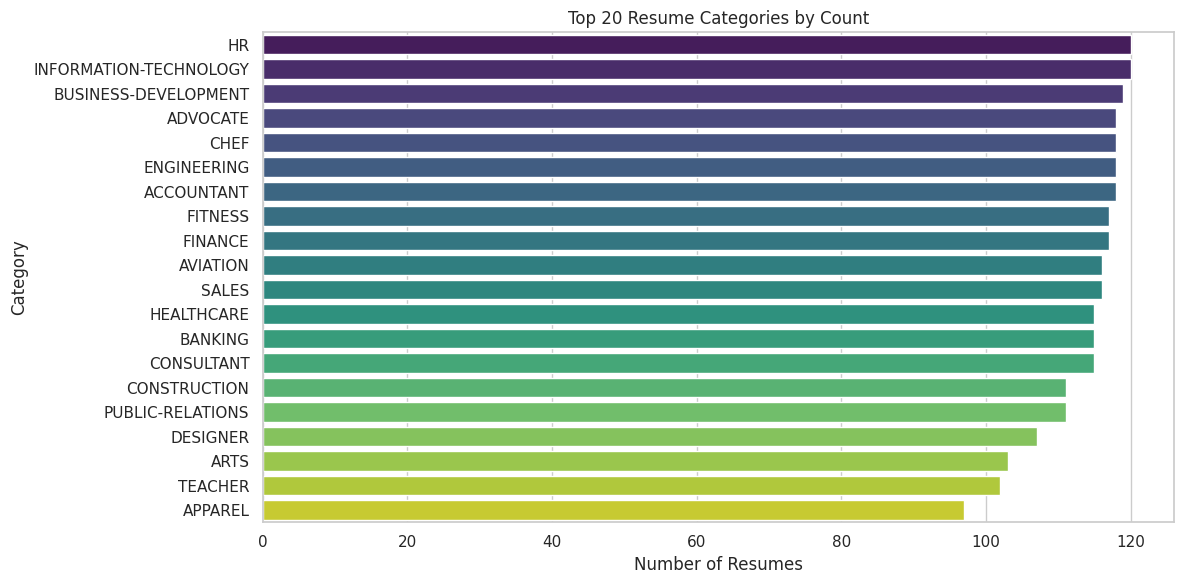

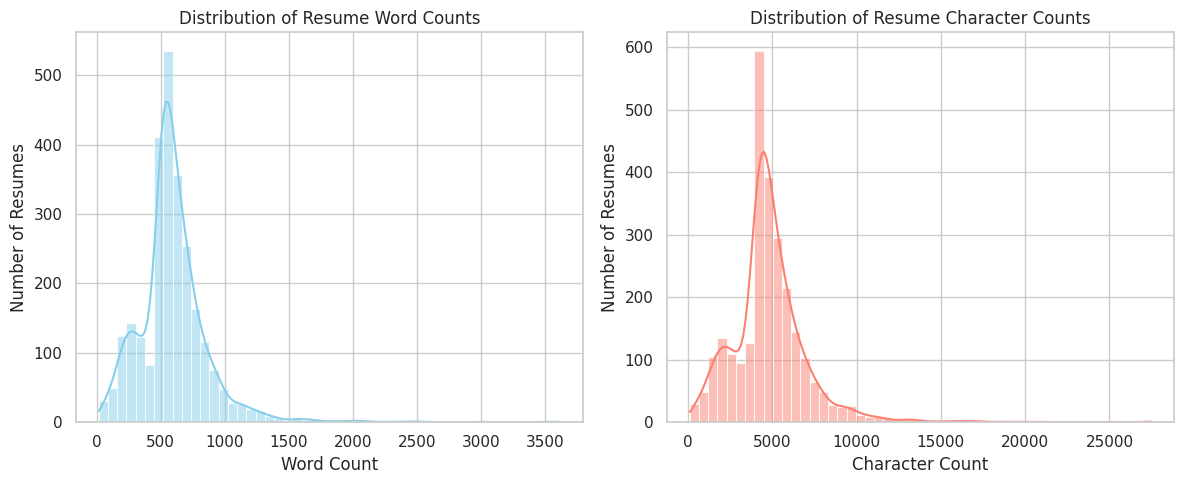

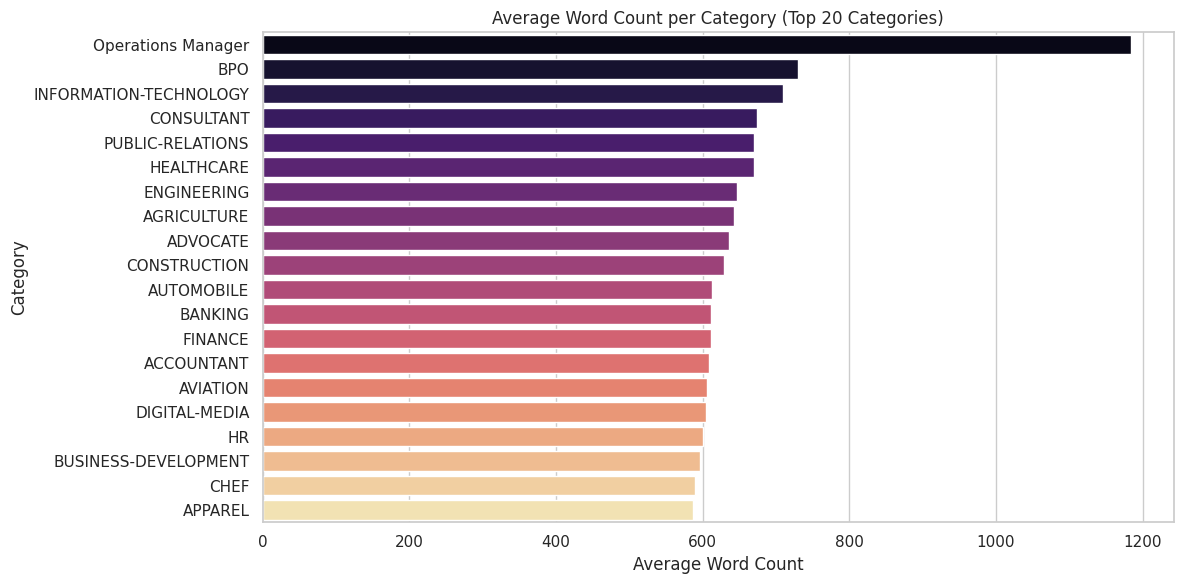

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# ---- 1️⃣ Category distribution ----
plt.figure(figsize=(12,6))
top_categories = all_resumes_df['category'].value_counts().head(20)  # top 20 categories
sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis")
plt.title("Top 20 Resume Categories by Count")
plt.xlabel("Number of Resumes")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

# ---- 2️⃣ Resume length distributions ----
plt.figure(figsize=(12,5))

# Word count histogram
plt.subplot(1,2,1)
sns.histplot(all_resumes_df['word_count'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Resume Word Counts")
plt.xlabel("Word Count")
plt.ylabel("Number of Resumes")

# Character count histogram
plt.subplot(1,2,2)
sns.histplot(all_resumes_df['char_count'], bins=50, kde=True, color='salmon')
plt.title("Distribution of Resume Character Counts")
plt.xlabel("Character Count")
plt.ylabel("Number of Resumes")

plt.tight_layout()
plt.show()

# ---- 3️⃣ Optional: Word count per category ----
plt.figure(figsize=(12,6))
avg_words_per_category = all_resumes_df.groupby('category')['word_count'].mean().sort_values(ascending=False).head(20)
sns.barplot(x=avg_words_per_category.values, y=avg_words_per_category.index, palette="magma")
plt.title("Average Word Count per Category (Top 20 Categories)")
plt.xlabel("Average Word Count")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


## Step 5: Create Embeddings

Create embeddings for all resumes using sentence-transformers model.


In [ ]:
# Step 5/6: Create Documents, Embeddings (all-MiniLM-L6-v2) and store in LangChain Chroma
print("🔁 Creating LangChain Document objects and initializing embeddings/vectorstore...")

# Create langchain Document objects from all_resumes (from Step 4)
documents = [
    Document(page_content=r["text"], metadata={"id": r["id"], "category": r["category"], "source": r["source"]})
    for r in all_resumes
]

# Initialize HuggingFaceEmbeddings all-MiniLM-L6-v2
print("🔬 Initializing HuggingFaceEmbeddings (all-MiniLM-L6-v2)...")
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Create / load Chroma via LangChain wrapper
persist_dir = "./chroma_db"
print(f"🗄️ Creating/Loading Chroma vectorstore at {persist_dir}...")
vectorstore = Chroma.from_documents(
    documents,
    embeddings,
    persist_directory=persist_dir,
    collection_name="resumes"
)

# Persist to disk
try:
    vectorstore.persist()
except Exception:
    # some langchain/chroma versions persist automatically
    pass
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})
len(documents)
hits = retriever.invoke("python data engineer with airflow and aws")
for h in hits:
    print(h.metadata, "→", h.page_content[:160].replace("\n", " "), "…")


print(f"✅ Stored {len(documents)} resumes in Chroma (collection='resumes').")

🔁 Creating LangChain Document objects and initializing embeddings/vectorstore...
🔬 Initializing HuggingFaceEmbeddings (all-MiniLM-L6-v2)...
🗄️ Creating/Loading Chroma vectorstore at ./chroma_db...
{'source': 'Resume.csv', 'id': 'resume1_20824105', 'category': 'INFORMATION-TECHNOLOGY'} → information technology aws admin intern experience information technology aws admin intern <NUM> <NUM> company name city state researched implemented secure clo …
{'id': 'resume2_553', 'source': 'UpdatedResumeDataSet.csv', 'category': 'Python Developer'} → technical proficiency platform ubuntufedoracent oswindows database mysql language python tensorflow numpy c c education detail january <NUM> computer engineerin …
{'id': 'resume1_50328713', 'source': 'Resume.csv', 'category': 'ENGINEERING'} → engineering intern skill c python matlab git bash r sql basic experienced linuxunix using high performance computing cluster machine learning tool library sciki …
{'id': 'resume2_599', 'source': 'UpdatedResumeDat

## Step 6 – Simple Evaluation of Embeddings
To make sure our embeddings and Chroma vector database work correctly,  
we perform a **quick qualitative test** instead of complex metrics.

We randomly select a few resumes, use them as queries,  
and check whether the **top similar resumes retrieved** belong to the same **category**.

If most of the retrieved results share the same category,  
it indicates that the **embedding model (all-MiniLM-L6-v2)** has successfully grouped  
similar resumes together in the vector space.


In [ ]:
# --- Step 6: Simple Evaluation (Category Consistency Check) ---
import random

print("\n🔍 Quick evaluation of embedding quality...")

# pick 3 random resumes to test
sample_docs = random.sample(documents, 3)

for i, doc in enumerate(sample_docs, 1):
    query_text = doc.page_content[:200]
    true_cat = doc.metadata["category"]

    print(f"\n===== Test {i} =====")
    print(f"🎯 Query category: {true_cat}")
    print(f"🗂️ Query preview: {query_text[:150].replace('\n',' ')}...")

    # Retrieve top 5 similar resumes
    hits = retriever.invoke(query_text)

    print("Top similar resumes:")
    for h in hits[:5]:
        print(f"  → Category: {h.metadata['category']}")



🔍 Quick evaluation of embedding quality...

===== Test 1 =====
🎯 Query category: BUSINESS-DEVELOPMENT
🗂️ Query preview: international business development manager summary charismatic business professional expertise business development product strategy marketing sale ef...
Top similar resumes:
  → Category: BUSINESS-DEVELOPMENT
  → Category: BUSINESS-DEVELOPMENT
  → Category: BUSINESS-DEVELOPMENT
  → Category: BUSINESS-DEVELOPMENT
  → Category: BUSINESS-DEVELOPMENT

===== Test 2 =====
🎯 Query category: HR
🗂️ Query preview: hr coordinator summary highly accomplish human resource professional proficient developing policy standard operating procedure best practice proven ex...
Top similar resumes:
  → Category: HR
  → Category: HR
  → Category: HR
  → Category: HR
  → Category: HR

===== Test 3 =====
🎯 Query category: CONSULTANT
🗂️ Query preview: consultant career focus obtain position area sap consulting utilizing skill academic background past work experience thus encouraging career ad

## Step 7: Setup Groq Cloud LLM

Initialize Groq Cloud LLM for intelligent analysis and ranking.


In [ ]:
# Step 7: Setup Groq Cloud LLM and LangChain RAG components
print("🤖 Setting up Groq Cloud LLM and LangChain RAG components...")

import os, re, json
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

# Set API key
os.environ["GROQ_API_KEY"] = "ur_api_key_here"
GROQ_API_KEY = os.environ.get("GROQ_API_KEY")
if not GROQ_API_KEY:
    print("⚠️ Warning: GROQ_API_KEY not found in environment. Set GROQ_API_KEY before running LLM calls.")

# Initialize Groq LLM
try:
    llm = ChatGroq(
        groq_api_key=GROQ_API_KEY,
        model_name="meta-llama/llama-4-scout-17b-16e-instruct",
        temperature=0.1,
        top_p=0.9,
        max_tokens=1024,
        seed=1,
    )
    print("✅ Groq Cloud LLM (ChatGroq) initialized.")
except Exception as e:
    print(f"⚠️ Groq initialization failed: {e}")
    llm = None

# Retriever (Vector Search)
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

# Human-friendly LLM evaluation prompt
augmentation_prompt = PromptTemplate(
    input_variables=["resume_text", "job_description"],
    template=(
        "You are an HR expert reviewing a candidate's resume against a job description.\n"
        "Read the JOB DESCRIPTION and RESUME carefully.\n"
        "Provide a concise, human-friendly evaluation with:\n"
        "1) A score out of 10 reflecting overall suitability.\n"
        "2) Explanation of matched skills, missing skills, experience, leadership, and tech level.\n"
        "3) Reasons why this candidate is a strong or weak match.\n\n"
        "JOB DESCRIPTION:\n{job_description}\n\n"
        "RESUME:\n{resume_text}\n\n"
        "Your output should be human-readable text, like:\n"
        "\"Score: 7/10. The candidate matches Python and AWS skills, lacks Airflow experience. "
        "They have 4 years experience, slightly below requirement of 5 years. Leadership experience is present. Overall fit is good because...\""
    )
)
augmentation_chain = LLMChain(llm=llm, prompt=augmentation_prompt, output_key="analysis")
extract = augmentation_chain  # alias for convenience

# Resume pre-processor (keep more context for LLM)
def prepare_resume_text(text, head_chars=6000, tail_chars=3000):
    text = text or ""
    text = re.sub(r'\s+', ' ', text).strip()
    if len(text) <= head_chars + tail_chars:
        return text
    return text[:head_chars] + "\n...\n" + text[-tail_chars:]

# Helper: extract numeric score from LLM evaluation
def extract_score(evaluation_text):
    match = re.search(r'Score[:\s]+(\d+(?:\.\d+)?)/10', evaluation_text)
    if match:
        return float(match.group(1))
    return 0.0

# Ranking resumes using hybrid scoring (30% embeddings, 70% LLM)
def rank_resumes(job_description, top_k=5):
    pairs = vectorstore.similarity_search_with_relevance_scores(job_description, k=max(2*top_k, 12))
    ranked = []
    for doc, sim in pairs:
        evaluation_text = extract.run({
            "resume_text": prepare_resume_text(doc.page_content),
            "job_description": job_description
        })
        llm_score = extract_score(evaluation_text)  # 0-10 scale
        # Combine: 30% semantic similarity + 70% LLM score (normalized to 0-10)
        final_score = round(0.3 * (sim * 10) + 0.7 * llm_score, 2)

        ranked.append({
            "evaluation": evaluation_text,
            "meta": doc.metadata,
            "preview": doc.page_content[:240].replace("\n", " "),
            "semantic_similarity": round(sim, 3),
            "llm_score": llm_score,
            "final_score": final_score
        })

    # Sort by hybrid final_score descending
    ranked.sort(key=lambda x: x["final_score"], reverse=True)
    return ranked[:top_k]




🤖 Setting up Groq Cloud LLM and LangChain RAG components...
✅ Groq Cloud LLM (ChatGroq) initialized.


In [ ]:

# Demo: run ranking and print results
jd = "Senior Data Engineer with Python, sql, AWS; 5+ years; leadership a plus."
res = rank_resumes(jd, top_k=5)

print("\nJob Description:", jd, "\n")
for i, r in enumerate(res, 1):
    print(f"Candidate #{i} | Final Score: {r['final_score']}/10 (LLM: {r['llm_score']}/10, Emb: {round(r['semantic_similarity']*10,2)}/10)")
    print(f"Meta: {r['meta']}")
    print(r['evaluation'])
    print(f"Preview: {r['preview']}")
    print("-"*80)


Job Description: Senior Data Engineer with Python, sql, AWS; 5+ years; leadership a plus. 

Candidate #1 | Final Score: 6.37/10 (LLM: 8.0/10, Emb: 2.58/10)
Meta: {'source': 'Resume.csv', 'id': 'resume1_62994611', 'category': 'AGRICULTURE'}
Here's my evaluation:

**Score: 8/10**

The candidate has a strong technical background with experience in Python, SQL, and AWS-relevant skills such as Amazon (mentioned in the context of integrating Amazon APIs). Their experience in software development, data analysis, and visualization also aligns well with the Senior Data Engineer role.

**Matched skills:**

* Programming languages: Python, SQL, C, HTML, JavaScript
* Data analysis and visualization: Pandas, NumPy, Matplotlib, Tableau
* Relevant experience: Software development, data engineering, project management

**Missing skills:**

* None explicitly mentioned, but experience with AWS-specific services (e.g., S3, Glue, Redshift) and data engineering tools (e.g., Airflow, Spark) is not clear.

